# Spotify Top Tracks of the Decade

##  In this exercise I decided to use a data set from Spotify that contained the top 50 songs for each year from 2010-2019.  As a musician I was curious to see what a hit song in 2020 might look like (and how to write one!), and also to test my hypothesis that popular songs are getting more sad sounding.  Then for fun I decided to see if I could use Machine Learning to make playlists based off of their feature characteristics.

In [684]:
# Data set can be found here!

#                   https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year

### Import packages and read data into a dataframe

In [685]:
#first import of packages 

import numpy as np 
import pandas as pd 

import missingno as msgn

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import scatter_matrix
import seaborn as sns

import sklearn
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, MaxAbsScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import classification_report, silhouette_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


In [686]:
df = pd.read_csv(r'/Users/sambrady/Datasets/Spotify/top10s.csv', encoding = "ISO-8859-1")

df.head()

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


In [687]:
#Renaming the columns

df.rename(columns={'title':'Track Name','artist':'Artist Name','bpm':'Beats Per Minute','top genre':'Genre','nrgy':'Energy','dnce':'Danceability', 'dB':'Loudness dB','spch':'Speechiness','live':'Liveness','val':'Valence','dur':'Length','acous':'Acousticness','pop':'Popularity'},inplace=True)

df.drop('Unnamed: 0', inplace=True, axis=1)

df.head()

,Track Name,Artist Name,Genre,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


# Part 1 - EDA and Data Visualization

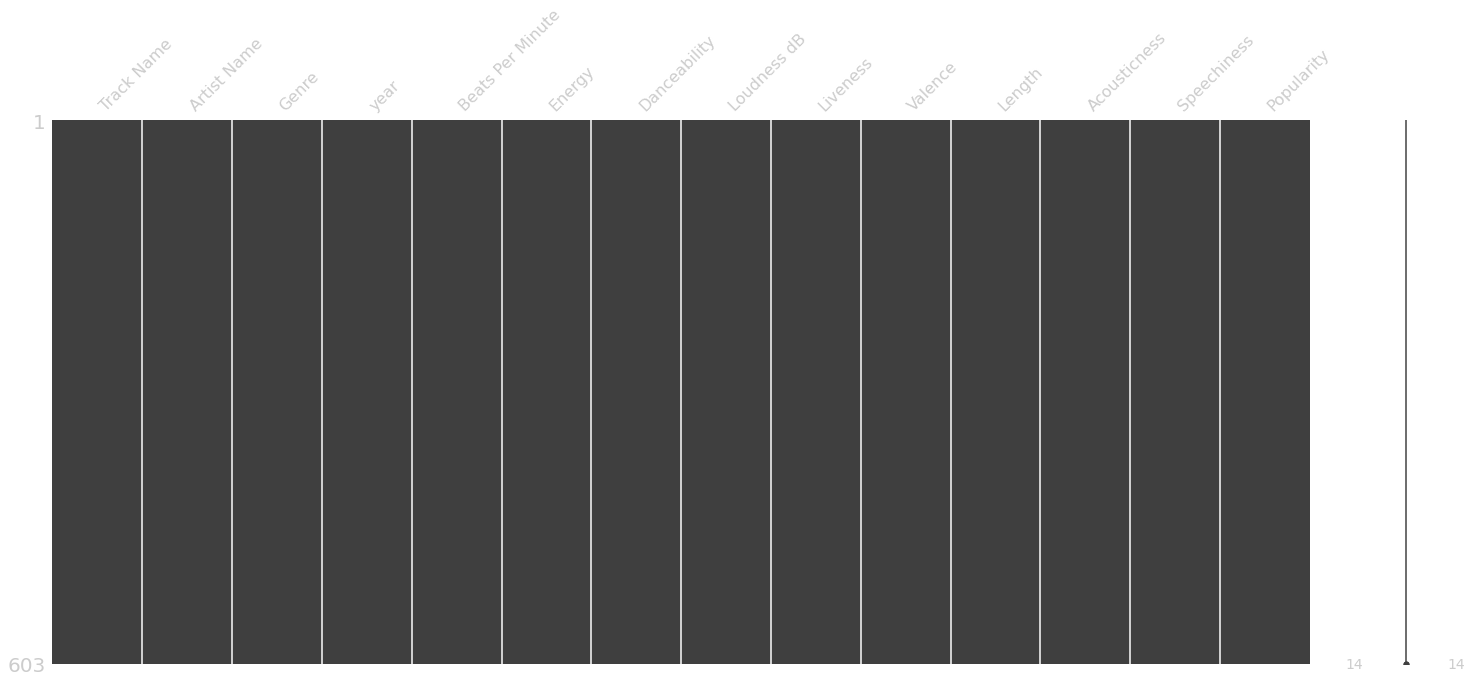

In [688]:
msgn.matrix(df)
plt.show()

In [689]:
df.isnull().values.any()

False

In [690]:
df.shape

(603, 14)

In [691]:
# The datatypes of the different columns

print(df.dtypes)

Track Name          object
Artist Name         object
Genre               object
year                 int64
Beats Per Minute     int64
Energy               int64
Danceability         int64
Loudness dB          int64
Liveness             int64
Valence              int64
Length               int64
Acousticness         int64
Speechiness          int64
Popularity           int64
dtype: object


In [692]:
# Get initial descriptive statistics on the columns

pd.set_option('precision', 3)

df.describe()

,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
count,603.000,603.000,603.000,603.000,603.000,603.000,603.000,603.000,603.000,603.000,603.000
mean,2014.592,118.546,70.504,64.380,-5.579,17.774,52.226,224.675,14.327,8.358,66.521
std,2.607,24.795,16.311,13.379,2.798,13.103,22.513,34.130,20.766,7.483,14.518
min,2010.000,0.000,0.000,0.000,-60.000,0.000,0.000,134.000,0.000,0.000,0.000
25%,2013.000,100.000,61.000,57.000,-6.000,9.000,35.000,202.000,2.000,4.000,60.000
50%,2015.000,120.000,74.000,66.000,-5.000,12.000,52.000,221.000,6.000,5.000,69.000
75%,2017.000,129.000,82.000,73.000,-4.000,24.000,69.000,239.500,17.000,9.000,76.000
max,2019.000,206.000,98.000,97.000,-2.000,74.000,98.000,424.000,99.000,48.000,99.000


In [693]:
df.describe(include=[np.object])

,Track Name,Artist Name,Genre
count,603,603,603
unique,584,184,50
top,Just the Way You Are,Katy Perry,dance pop
freq,2,17,327


## Categorical EDA with bar graphs to see most popular Artists, Genres, and Tracks

In [694]:
plt.style.use("dark_background")

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '#cccccc'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#404040'  # dark grey
    
plt.rcParams['axes.axisbelow'] = True

In [696]:
#Calculating the number of songs of each genre

popular_genre = df.groupby('Genre').size()

popular_genre = popular_genre.sort_values(ascending=False)

genre_top20 = popular_genre[0:20,]

genre_top20 = genre_top20.sort_values(ascending=False)

genre_top20 = pd.DataFrame(genre_top20, columns = [ 'Number of Songs'])

genre_top20

,Number of Songs
Genre,
dance pop,327
pop,60
canadian pop,34
barbadian pop,15
boy band,15
electropop,13
british soul,11
big room,10
canadian contemporary r&b,9


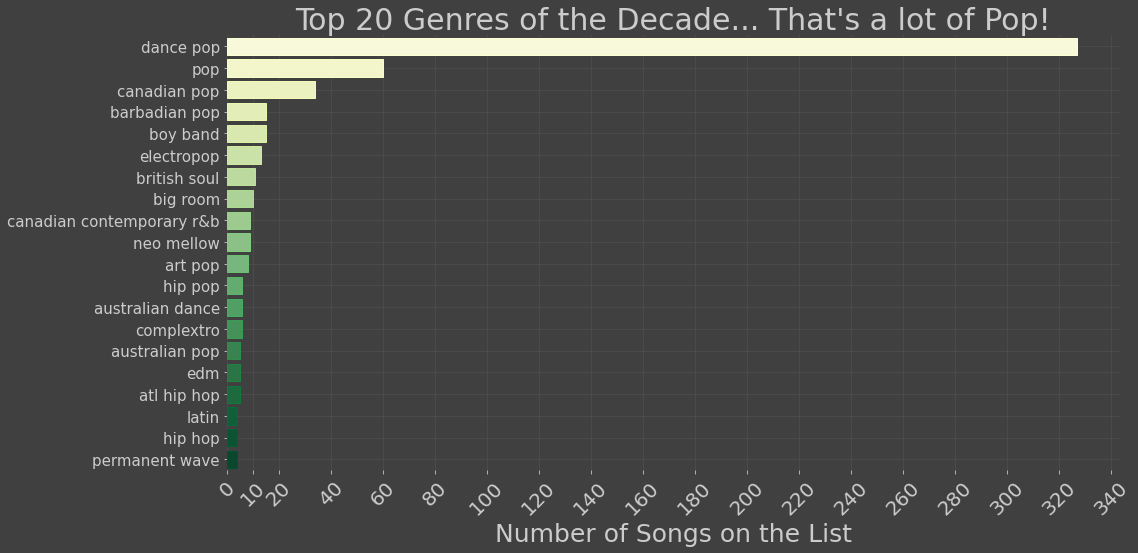

In [697]:


plt.figure(figsize=(16,8))

cmap = sns.color_palette("YlGn", 20)

ax = sns.barplot(x = 'Number of Songs' , y = genre_top20.index , data = genre_top20, orient = 'h', palette=cmap, edgecolor=cmap)

plt.title("Top 20 Genres of the Decade... That's a lot of Pop!",fontsize=30)
plt.xlabel('Number of Songs on the List', fontsize=25)
plt.ylabel('Genre', fontsize=10)

xticks = [0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340]

plt.grid(color='#4d4d4d')
plt.xticks(xticks, size=20,rotation=45)
plt.yticks(size=15)
plt.ylabel('')
sns.despine(bottom=True, left=True)

plt.show()

In [698]:
#Calculating the least popular genres


genre_bot30 = popular_genre[20:,]

genre_bot30 = genre_bot30.sort_values(ascending=True)

genre_bot30 = pd.DataFrame(genre_bot30, columns = [ 'Number of Songs'])

genre_bot30

,Number of Songs
Genre,
contemporary country,1
canadian latin,1
electro house,1
celtic rock,1
hollywood,1
house,1
french indie pop,1
australian hip hop,1
irish singer-songwriter,1


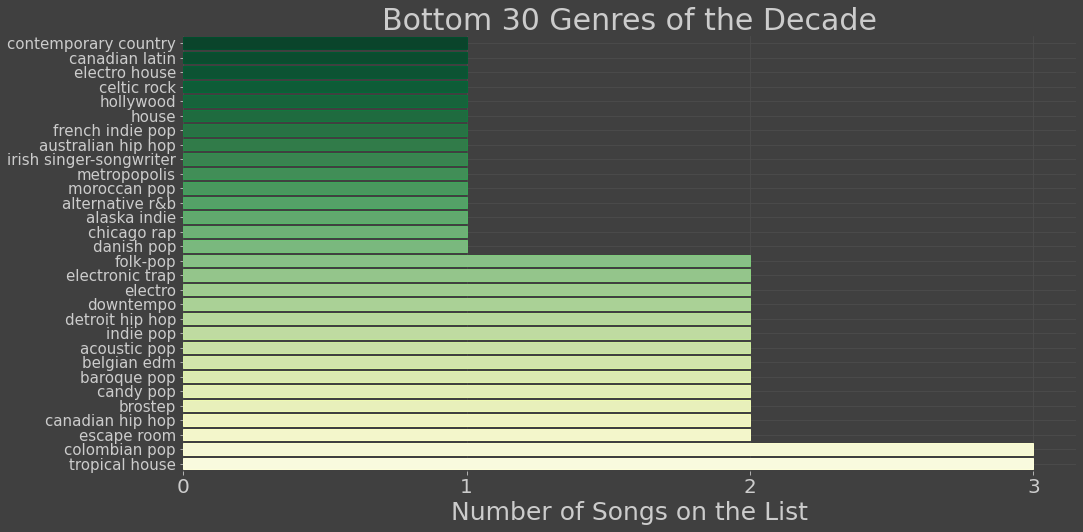

In [699]:
#Pie chart to show bottom 30 genres

plt.figure(figsize=(16,8))

cmap = sns.color_palette("YlGn_r", 30)

ax = sns.barplot(x = 'Number of Songs' , y = genre_bot30.index , data = genre_bot30, orient = 'h', palette=cmap, edgecolor=cmap)

plt.title("Bottom 30 Genres of the Decade",fontsize=30)
plt.xlabel('Number of Songs on the List', fontsize=25)
plt.ylabel('Genre', fontsize=10)

plt.grid(color='#4d4d4d')
plt.xticks(np.arange(0, 4, 1), size=20)
plt.yticks(size=15)
plt.ylabel('')
sns.despine(bottom=True, left=True)

plt.show()

In [700]:
#Calculating the number of songs by each of the artists


popular_artist = df.groupby('Artist Name').size()

popular_artist = popular_artist.sort_values(ascending=False)

popular_artist

artist_list=df['Artist Name'].values.tolist()

artist_top25 = popular_artist[0:25,]

artist_top25 = artist_top25.sort_values(ascending=False)

artist_top25 = pd.DataFrame(artist_top25, columns = [ 'Number of Songs'])

artist_top25

,Number of Songs
Artist Name,
Katy Perry,17
Justin Bieber,16
Maroon 5,15
Rihanna,15
Lady Gaga,14
Bruno Mars,13
The Chainsmokers,11
Pitbull,11
Ed Sheeran,11


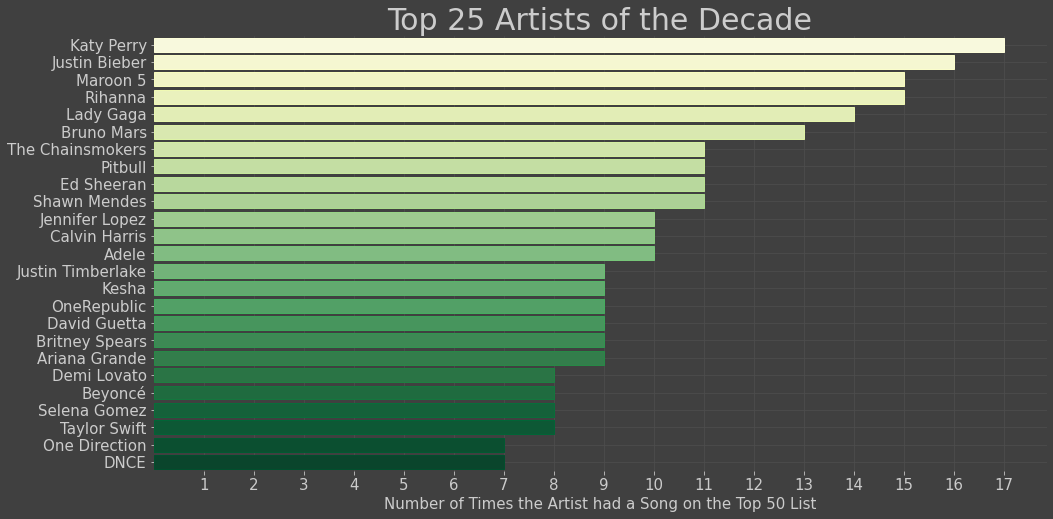

In [701]:

plt.figure(figsize=(16,8))

cmap = sns.color_palette("YlGn", 25)

ax = sns.barplot(x = 'Number of Songs' , y = artist_top25.index , data = artist_top25, orient = 'h', palette=cmap, edgecolor=cmap)

plt.xticks(np.arange(1, 18, 1), size=15)
plt.yticks(size=15)
plt.ylabel('')
plt.title("Top 25 Artists of the Decade",fontsize=30)
plt.xlabel('Number of Times the Artist had a Song on the Top 50 List', fontsize=15)
plt.grid(color='#4d4d4d')
sns.despine(bottom=True, left=True)

plt.show()

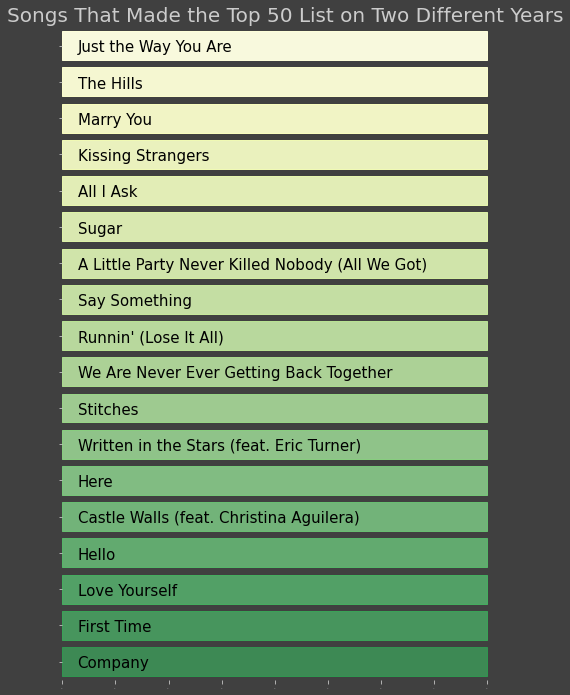

In [702]:
# Songs that made the top 50 list twice

plt.figure(figsize=(8,12))

plt.rcParams['axes.axisbelow'] = False


tracks = pd.value_counts(df['Track Name']).iloc[:18].index

cmap = sns.color_palette("YlGn", 25)

sns.countplot(y= df['Track Name'], order = tracks, orient = 'v', palette=cmap, edgecolor=cmap)

plt.title('Songs That Made the Top 50 List on Two Different Years',fontsize=20)
plt.ylabel('')
plt.xlabel('')

plt.yticks(fontsize=15, horizontalalignment= 'left', color='black', position=(0.05,0))

plt.xticks(fontsize=0)


ax.tick_params(axis='y', which='major', direction='in', colors='black', pad=0.1, labelcolor='white', zorder=10, labelright=True)

sns.despine(bottom=True, left=True)

plt.show()

plt.rcParams['axes.axisbelow'] = True

## Investigating  bad data

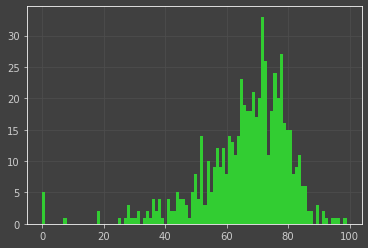

In [703]:
# Plotting a histogram to show the spread of Popularity since we notice some strange stats worth investigating

plt.hist(df['Popularity'],bins=100, color='limegreen')
plt.grid(color='#4d4d4d')
plt.show()

In [704]:
# Investigating low popularity

low_pop = df[df['Popularity'] <= 20]

low_pop

,Track Name,Artist Name,Genre,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
50,Hello,Martin Solveig,big room,2010,128,98,67,-3,10,45,191,1,3,0
103,Muny - Album Version (Edited),Nicki Minaj,dance pop,2011,98,72,80,-5,19,53,227,56,33,7
138,Blow Me (One Last Kiss),P!nk,dance pop,2012,114,92,60,-3,25,75,256,0,4,0
267,Not a Bad Thing,Justin Timberlake,dance pop,2014,86,73,59,-6,38,46,266,27,6,0
361,Dangerous,Jennifer Hudson,dance pop,2015,109,53,90,-5,8,65,255,0,5,18
362,L.A.LOVE (la la),Fergie,dance pop,2015,202,39,48,-8,26,27,193,2,9,0
441,Behind Your Back,Nelly Furtado,canadian latin,2016,98,47,80,-10,7,69,228,25,4,18
442,Million Years Ago,Adele,british soul,2016,0,0,0,-60,0,0,227,0,0,0


In [705]:
# Inspect bad data...  How can the popularity be 0 if these are top 50 songs? Perhaps it was scaled data?

df.loc[df['Popularity']==0]

,Track Name,Artist Name,Genre,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
50,Hello,Martin Solveig,big room,2010,128,98,67,-3,10,45,191,1,3,0
138,Blow Me (One Last Kiss),P!nk,dance pop,2012,114,92,60,-3,25,75,256,0,4,0
267,Not a Bad Thing,Justin Timberlake,dance pop,2014,86,73,59,-6,38,46,266,27,6,0
362,L.A.LOVE (la la),Fergie,dance pop,2015,202,39,48,-8,26,27,193,2,9,0
442,Million Years Ago,Adele,british soul,2016,0,0,0,-60,0,0,227,0,0,0


In [706]:
# drop bad data

df = df.drop(df.index[442])

df = df.reset_index(drop=True)

# check it's gone

df.iloc[442]

Track Name          Shape of You
Artist Name           Ed Sheeran
Genre                        pop
year                        2017
Beats Per Minute              96
Energy                        65
Danceability                  83
Loudness dB                   -3
Liveness                       9
Valence                       93
Length                       234
Acousticness                  58
Speechiness                    8
Popularity                    87
Name: 442, dtype: object

In [707]:

df.head()

,Track Name,Artist Name,Genre,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


# Part 2 - Statistical EDA, Normalization, and PCA

In [708]:
# get descriptive statistics on the columns

pd.set_option('precision', 3)

df.describe()

,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
count,602.000,602.000,602.000,602.000,602.000,602.000,602.000,602.000,602.000,602.000,602.000
mean,2014.590,118.743,70.621,64.487,-5.488,17.804,52.312,224.671,14.350,8.372,66.631
std,2.609,24.339,16.068,13.129,1.705,13.093,22.431,34.158,20.775,7.482,14.274
min,2010.000,43.000,4.000,23.000,-15.000,2.000,4.000,134.000,0.000,3.000,0.000
25%,2013.000,100.000,61.000,57.000,-6.000,9.000,35.000,202.000,2.000,4.000,60.000
50%,2015.000,120.000,74.000,66.000,-5.000,12.000,52.000,220.500,6.000,5.000,69.000
75%,2017.000,129.000,82.000,73.000,-4.000,24.000,69.000,239.750,17.000,9.000,76.000
max,2019.000,206.000,98.000,97.000,-2.000,74.000,98.000,424.000,99.000,48.000,99.000


In [709]:
# get df ready for scatter matrix and scaling

df_features = df.drop(df.columns[[0, 1, 2, 3]], axis =1)

df_features.head()

,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
0,97,89,67,-4,8,80,217,19,4,83
1,87,93,75,-5,52,64,263,24,23,82
2,120,84,76,-3,29,71,200,10,14,80
3,119,92,70,-4,8,71,295,0,4,79
4,109,84,64,-5,9,43,221,2,4,78


## Normalization of the data to get the values between 0 and 1 in order to help with  PCA and regression analysis

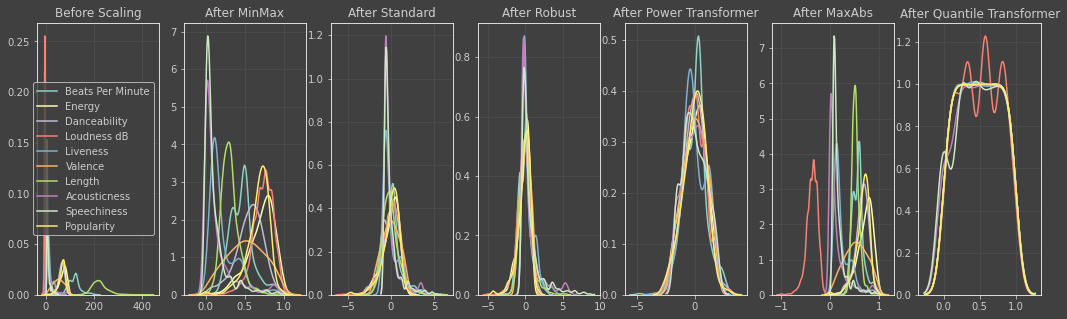

In [710]:
x = df_features.copy()


scaler = preprocessing.MinMaxScaler()
minmax_scaled_df = scaler.fit_transform(x)
minmax_scaled_df = pd.DataFrame(minmax_scaled_df, columns=x.columns)

scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled_df, columns=x.columns)
    
scaler = preprocessing.RobustScaler()
robust_scaled_df = scaler.fit_transform(x)
robust_scaled_df = pd.DataFrame(robust_scaled_df, columns=x.columns)

scaler = preprocessing.PowerTransformer()
power_scaled_df = scaler.fit_transform(x)
power_scaled_df = pd.DataFrame(power_scaled_df, columns=x.columns)

scaler = preprocessing.MaxAbsScaler()
maxabs_scaled_df = scaler.fit_transform(x)
maxabs_scaled_df = pd.DataFrame(maxabs_scaled_df, columns=x.columns)

scaler = preprocessing.QuantileTransformer()
quant_scaled_df = scaler.fit_transform(x)
quant_scaled_df = pd.DataFrame(quant_scaled_df, columns=x.columns)


fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(ncols=7, figsize=(18, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(x['Beats Per Minute'], ax=ax1)
sns.kdeplot(x['Energy'], ax=ax1)
sns.kdeplot(x['Danceability'], ax=ax1)
sns.kdeplot(x['Loudness dB'], ax=ax1)
sns.kdeplot(x['Liveness'], ax=ax1)
sns.kdeplot(x['Valence'], ax=ax1)
sns.kdeplot(x['Length'], ax=ax1)
sns.kdeplot(x['Acousticness'], ax=ax1)
sns.kdeplot(x['Speechiness'], ax=ax1)
sns.kdeplot(x['Popularity'], ax=ax1)
ax1.grid(color='#4d4d4d')

ax2.set_title('After MinMax')
sns.kdeplot(minmax_scaled_df['Beats Per Minute'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Energy'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Danceability'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Loudness dB'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Liveness'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Valence'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Length'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Acousticness'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Speechiness'], ax=ax2, legend=False)
sns.kdeplot(minmax_scaled_df['Popularity'], ax=ax2, legend=False)
ax2.grid(color='#4d4d4d')

ax3.set_title('After Standard')
sns.kdeplot(scaled_df['Beats Per Minute'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Energy'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Danceability'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Loudness dB'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Liveness'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Valence'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Length'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Acousticness'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Speechiness'], ax=ax3, legend=False)
sns.kdeplot(scaled_df['Popularity'], ax=ax3, legend=False)
ax3.grid(color='#4d4d4d')

ax4.set_title('After Robust')
sns.kdeplot(robust_scaled_df['Beats Per Minute'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Energy'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Danceability'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Loudness dB'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Liveness'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Valence'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Length'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Acousticness'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Speechiness'], ax=ax4, legend=False)
sns.kdeplot(robust_scaled_df['Popularity'], ax=ax4, legend=False)
ax4.grid(color='#4d4d4d')


ax5.set_title('After Power Transformer')
sns.kdeplot(power_scaled_df['Beats Per Minute'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Energy'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Danceability'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Loudness dB'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Liveness'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Valence'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Length'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Acousticness'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Speechiness'], ax=ax5, legend=False)
sns.kdeplot(power_scaled_df['Popularity'], ax=ax5, legend=False)
ax5.grid(color='#4d4d4d')

ax6.set_title('After MaxAbs')
sns.kdeplot(maxabs_scaled_df['Beats Per Minute'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Energy'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Danceability'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Loudness dB'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Liveness'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Valence'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Length'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Acousticness'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Speechiness'], ax=ax6, legend=False)
sns.kdeplot(maxabs_scaled_df['Popularity'], ax=ax6, legend=False)
ax6.grid(color='#4d4d4d')

ax7.set_title('After Quantile Transformer')
sns.kdeplot(quant_scaled_df['Beats Per Minute'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Energy'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Danceability'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Loudness dB'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Liveness'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Valence'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Length'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Acousticness'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Speechiness'], ax=ax7, legend=False)
sns.kdeplot(quant_scaled_df['Popularity'], ax=ax7, legend=False)
ax7.grid(color='#4d4d4d')

plt.show()

In [711]:
# scale the data with MinMax Scaler

df_norm = df_features.copy()

scaler = MinMaxScaler() 

df_norm = scaler.fit_transform(df_norm)

df_norm = pd.DataFrame(df_norm, columns = df_features.columns)

df_norm.describe()

,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
count,602.000,602.000,602.000,602.000,602.000,602.000,602.000,602.000,602.000,602.000
mean,0.465,0.709,0.561,0.732,0.219,0.514,0.313,0.145,0.119,0.673
std,0.149,0.171,0.177,0.131,0.182,0.239,0.118,0.210,0.166,0.144
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.350,0.606,0.459,0.692,0.097,0.330,0.234,0.020,0.022,0.606
50%,0.472,0.745,0.581,0.769,0.139,0.511,0.298,0.061,0.044,0.697
75%,0.528,0.830,0.676,0.846,0.306,0.691,0.365,0.172,0.133,0.768
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


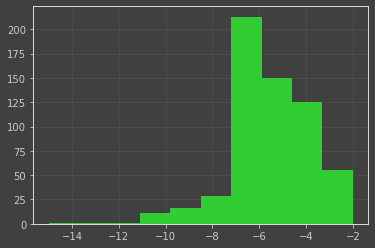

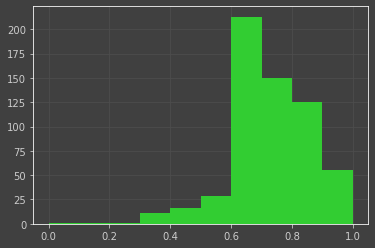

In [763]:
# plotting a histogram to show the difference (note the x-axis)

plt.hist(df_features['Loudness dB'], bins=10, color='limegreen')     #original data
plt.grid(color='#4d4d4d')
plt.show()


plt.hist(df_norm['Loudness dB'], bins=10, color='limegreen')          #standardized data
plt.grid(color='#4d4d4d')
plt.show()

## PCA (Principle Component Analysis) to reduce the feature columns

In [713]:
# fitting the PCA algorithm with our Data

pca = PCA().fit(df_norm)

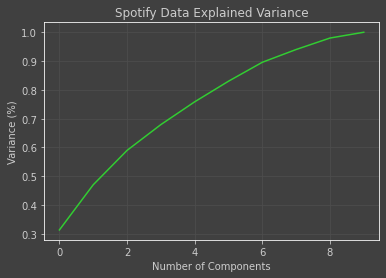

In [714]:
# plotting the Cumulative Summation of the Explained Variance

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='limegreen')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Spotify Data Explained Variance')
plt.grid(color='#4d4d4d')
plt.show()

In [715]:
# print the explained variance for each component

explained_variance = pca.explained_variance_ratio_

print(explained_variance)

[0.31390951 0.15676155 0.11926476 0.08954843 0.07909356 0.07149081
 0.06573916 0.04430419 0.03975113 0.0201369 ]


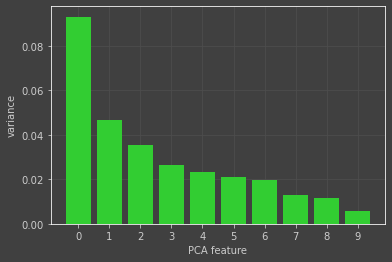

In [716]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_, color='limegreen')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.grid(color='#4d4d4d')
plt.show()

In [717]:
# how much variance can be explained for 8 components

print('The explained variance for this many components is:  ',explained_variance[0:8].sum())

The explained variance for this many components is:   0.9401119672148013


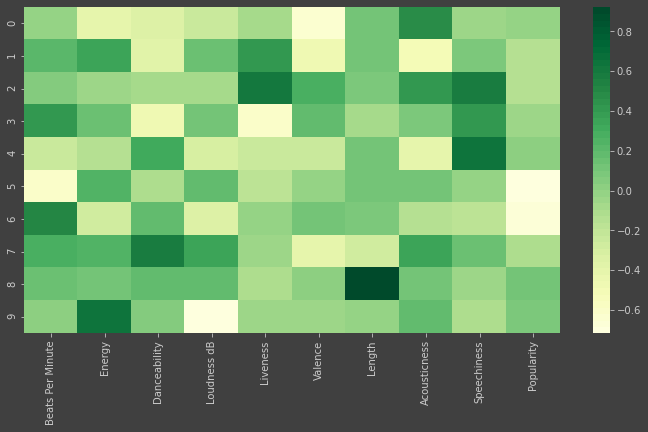

In [718]:
# visually inspect pca
cmap = sns.color_palette("YlGn", 50)
map = pd.DataFrame(pca.components_, columns=df_norm.columns)
plt.figure(figsize=(12,6))
sns.heatmap(map, cmap=cmap)
plt.show()

In [719]:
# choose number of components

pca = PCA(n_components = 8)

data_pca = pca.fit_transform(df_norm)

## Analyzing the features and their interdependencies

In [720]:
# Use a spearman correlation to measure the relationship between features

pd.set_option('display.width', 100)
pd.set_option('precision', 3)

correlation = df_norm.corr(method='spearman')

display(correlation)

,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
Beats Per Minute,1.000,0.141,-0.085,0.085,0.091,0.022,0.021,-0.160,0.053,-0.043
Energy,0.141,1.000,0.022,0.638,0.134,0.368,-0.137,-0.342,0.209,-0.151
Danceability,-0.085,0.022,1.000,0.077,-0.106,0.481,-0.173,-0.111,0.084,0.106
Loudness dB,0.085,0.638,0.077,1.000,0.053,0.327,-0.170,-0.172,0.054,-0.052
Liveness,0.091,0.134,-0.106,0.053,1.000,-0.059,0.066,-0.061,0.122,-0.101
Valence,0.022,0.368,0.481,0.327,-0.059,1.000,-0.258,-0.185,0.182,0.013
Length,0.021,-0.137,-0.173,-0.170,0.066,-0.258,1.000,0.045,-0.081,-0.079
Acousticness,-0.160,-0.342,-0.111,-0.172,-0.061,-0.185,0.045,1.000,-0.036,0.105
Speechiness,0.053,0.209,0.084,0.054,0.122,0.182,-0.081,-0.036,1.000,-0.025
Popularity,-0.043,-0.151,0.106,-0.052,-0.101,0.013,-0.079,0.105,-0.025,1.000


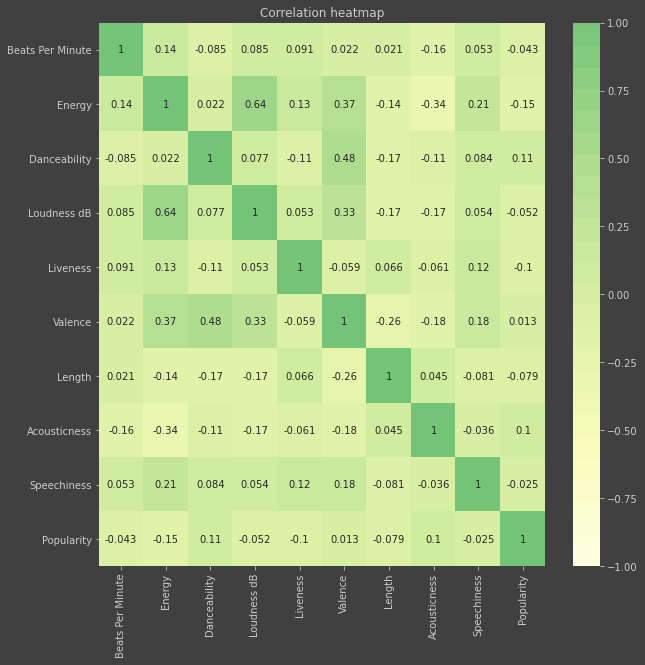

In [721]:
# heatmap of the correlation to visualize the relationships between features

plt.figure(figsize=(10,10))
plt.title('Correlation heatmap')
cmap = sns.color_palette("YlGn", 50)
sns.heatmap(correlation, annot = True, vmin=-1, vmax=1, cmap=cmap, center=1)

plt.show()

###  _**Happier songs are more danceable!**_

The spearman correlation is:   0.48128866476555415


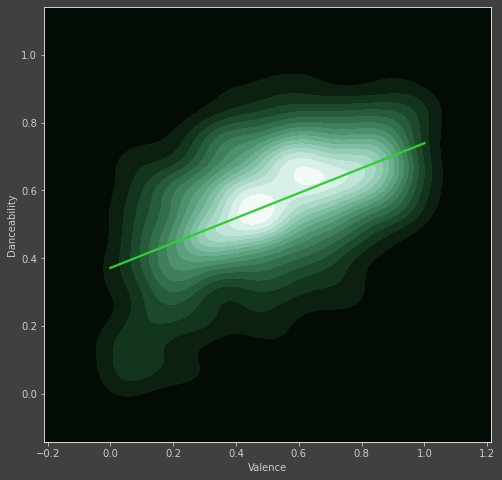

In [722]:
# Analysing the relationship between Danceablity and Valence

fig = plt.subplots(figsize = (8,8))

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True, start=5, rot=.1)

sns.regplot(x = 'Valence', y = 'Danceability', data = df_norm, color = 'limegreen')

sns.kdeplot(df_norm['Valence'], df_norm['Danceability'], cmap=cmap, shade=True, n_levels=16)

print('The spearman correlation is:  ',correlation['Danceability']['Valence'])

###  _**My hypothesis that popular songs are more depressing was wrong!**_

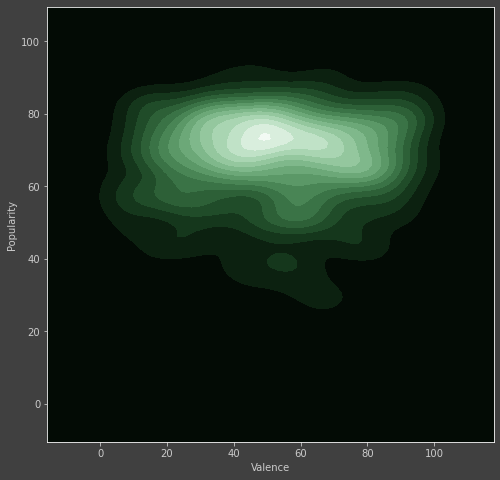

In [723]:
# analysing the relationship between valence vs popularity


fig = plt.subplots(figsize = (8,8))

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True, start=5, rot=0)

sns.kdeplot(df['Valence'], df['Popularity'], cmap=cmap, n_levels=16, shade=True)

###  _**Sadder songs do have less energy though!**_

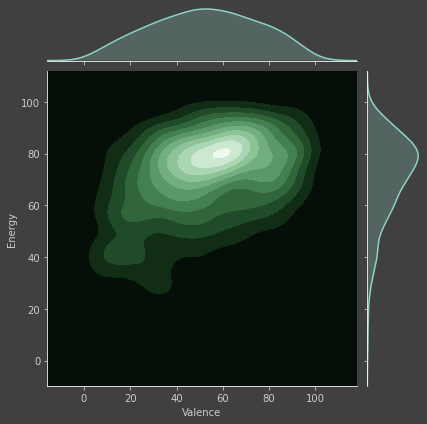

In [724]:
# analysing the relationship between valence vs energy

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True, start=5, rot=0)

sns.jointplot(x=df['Valence'], y=df['Energy'], data=df, kind="kde", cmap=cmap)

plt.show()

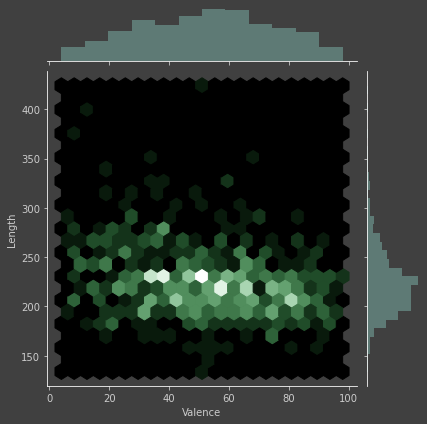

In [725]:
# analysing the relationship between valence vs length

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True, start=5, rot=0)

sns.jointplot(df['Valence'], df['Length'], kind="hex", cmap=cmap)

plt.show()

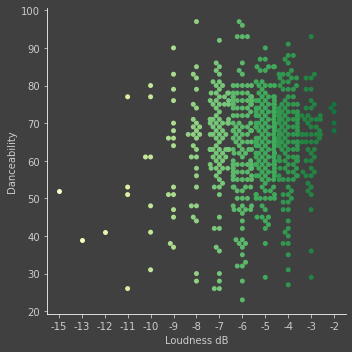

In [726]:
# analysing the relationship between loudness vs danceability

cmap = sns.color_palette("YlGn", 15)

sns.catplot(y="Danceability", x="Loudness dB", kind = "swarm", data = df_features, palette = cmap)

plt.show()

###  _**The most recent songs are the most popular!  ...this makes me question the Popularity score**_

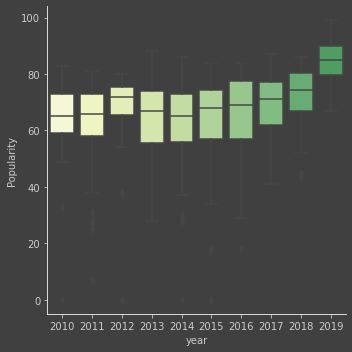

In [727]:
# analysing the spread of popularity throught the years

cmap = sns.color_palette("YlGn", 15)

sns.catplot(y = "Popularity", x = "year", kind = "box", data = df, palette = cmap)


plt.show()

## Analyzing the trends over the years

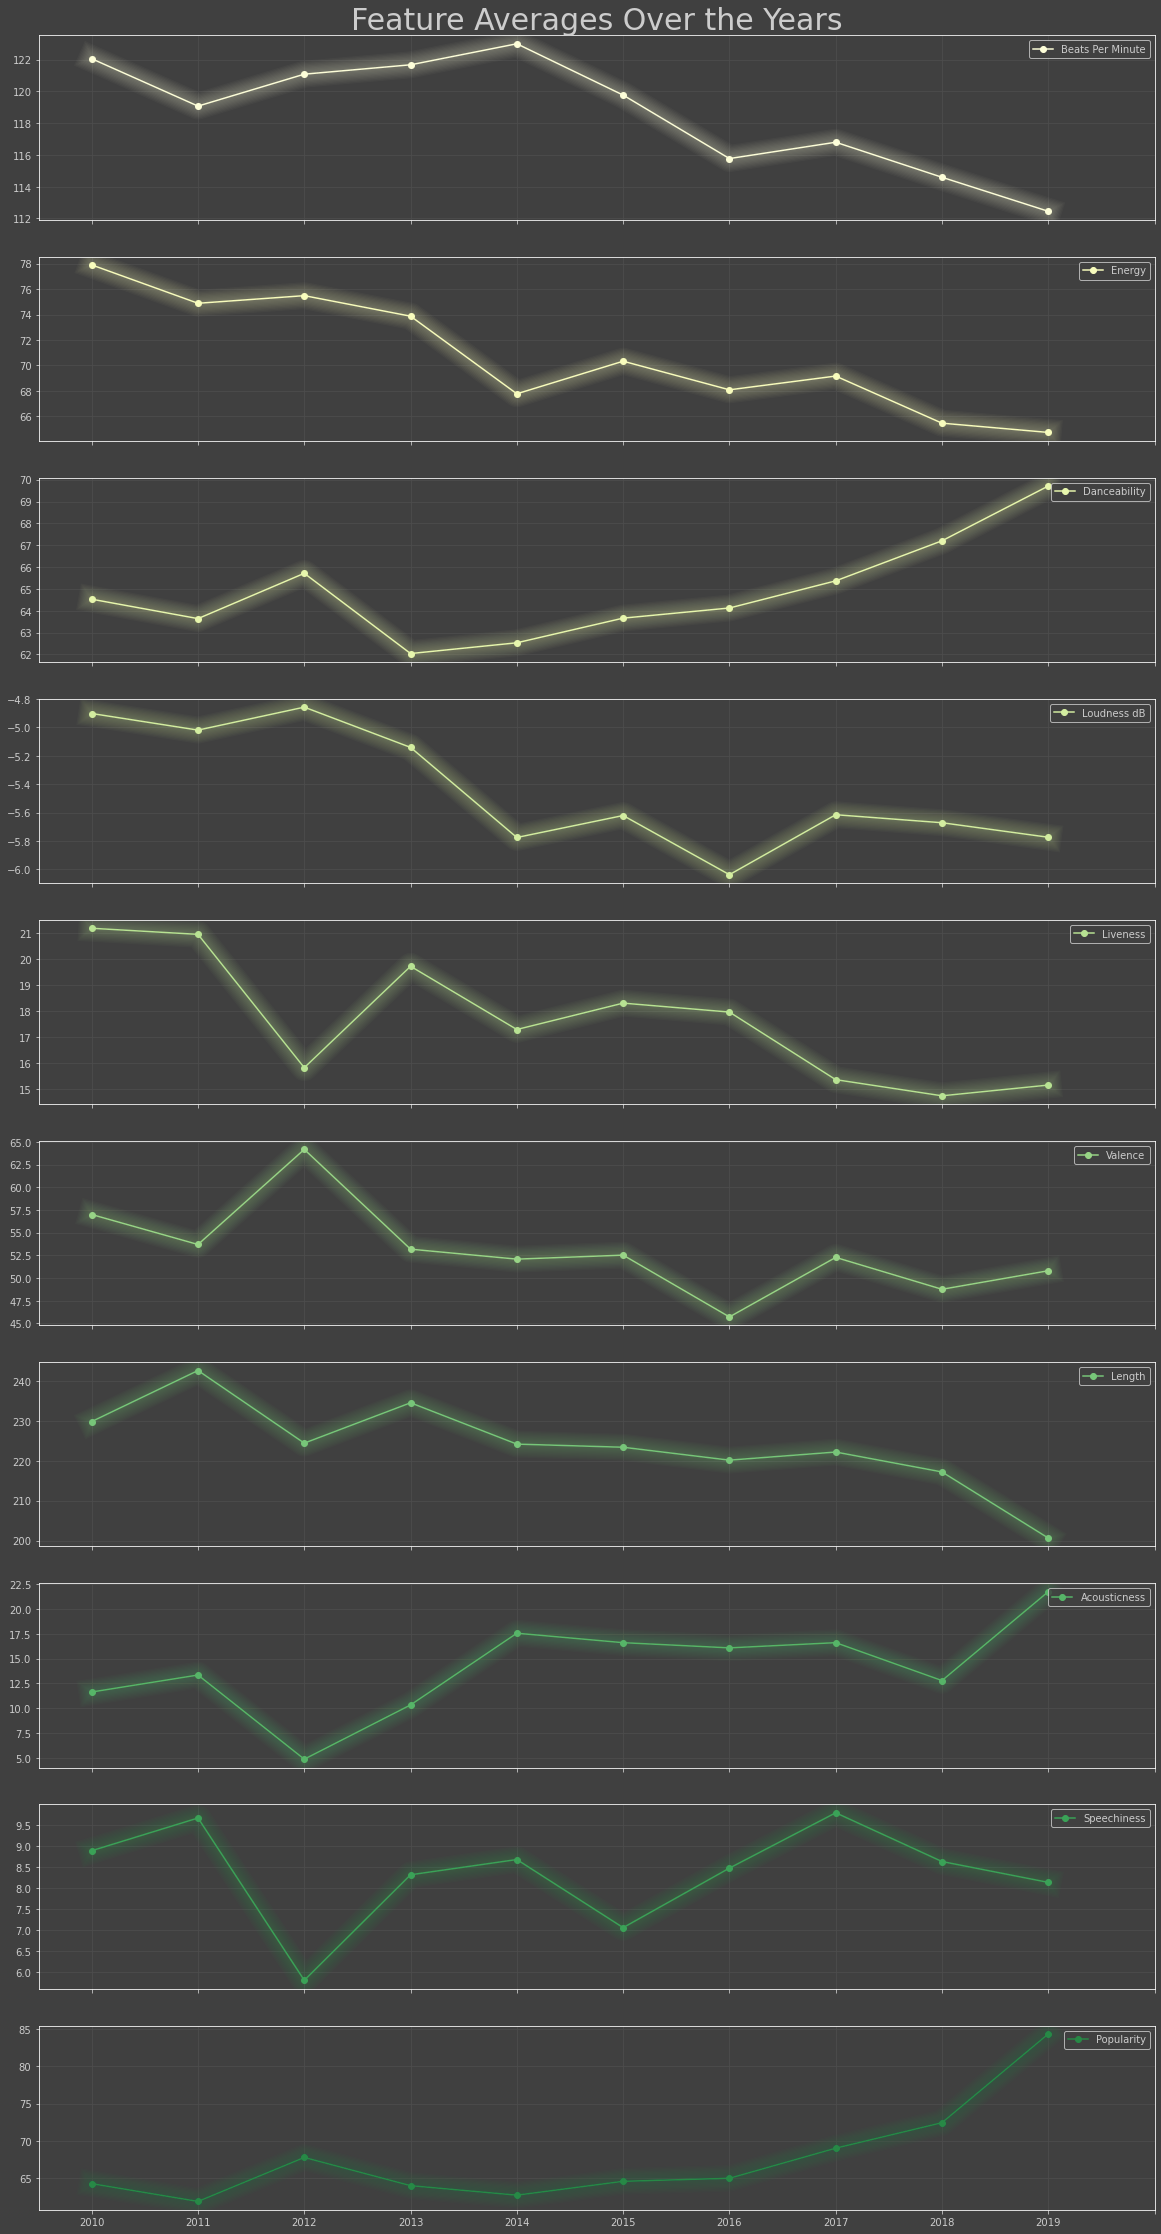

In [728]:
year_df = df.groupby(['year']).mean()


bpm = year_df.iloc[:,0]
energy = year_df.iloc[:,1]
dance = year_df.iloc[:,2]
loud = year_df.iloc[:,3]
live = year_df.iloc[:,4]
val = year_df.iloc[:,5]
length = year_df.iloc[:,6]
acoust = year_df.iloc[:,7]
speech = year_df.iloc[:,8]
pop = year_df.iloc[:,9]


fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(ncols=1, nrows=10, sharey=False, sharex=True, figsize=(20,40))

cmap = sns.color_palette("YlGn", 25)
n_shades = 10
diff_linewidth = 2.5
alpha_value = 0.3 / n_shades


bpm.reset_index(drop=True).plot(marker='o', x= bpm.index, y=bpm.values, ax=ax1, color=cmap[0], legend=True)

for n in range(1, n_shades+1):
    bpm.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax1, color=cmap[0])


ax1.grid(color='#4d4d4d')
ax1.set_xlim(-0.5, 10) 
ax1.set_xlabel('')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_xticklabels(np.arange(2010, 2020, 1))
ax1.set_title('Feature Averages Over the Years', fontsize=30)


energy.reset_index(drop=True).plot(marker='o', x= energy.index, y=energy.values, ax=ax2, color=cmap[2], legend=True)

for n in range(1, n_shades+1):
    energy.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax2, color=cmap[2])

ax2.grid(color='#4d4d4d')
ax2.set_xlim(-0.5, 10) 
ax2.set_xlabel('')
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_xticklabels(np.arange(2010, 2020, 1))



dance.reset_index(drop=True).plot(marker='o', x= dance.index, y=dance.values, ax=ax3, color=cmap[4], legend=True)

for n in range(1, n_shades+1):
    dance.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax3, color=cmap[4])

ax3.grid(color='#4d4d4d')
ax3.set_xlim(-0.5, 10) 
ax3.set_xlabel('')
ax3.set_xticks(np.arange(0, 11, 1))
ax3.set_xticklabels(np.arange(2010, 2020, 1))


loud.reset_index(drop=True).plot(marker='o', x= loud.index, y=loud.values, ax=ax4, color=cmap[6], legend=True)

for n in range(1, n_shades+1):
    loud.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax4, color=cmap[6])

ax4.grid(color='#4d4d4d')
ax4.set_xlim(-0.5, 10) 
ax4.set_xlabel('')
ax4.set_xticks(np.arange(0, 11, 1))
ax4.set_xticklabels(np.arange(2010, 2020, 1))


live.reset_index(drop=True).plot(marker='o', x= live.index, y=live.values, ax=ax5, color=cmap[8], legend=True)

for n in range(1, n_shades+1):
    live.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax5, color=cmap[8])

ax5.grid(color='#4d4d4d')
ax5.set_xlim(-0.5, 10) 
ax5.set_xlabel('')
ax5.set_xticks(np.arange(0, 11, 1))
ax5.set_xticklabels(np.arange(2010, 2020, 1))


val.reset_index(drop=True).plot(marker='o', x= val.index, y=val.values, ax=ax6, color=cmap[10], legend=True)

for n in range(1, n_shades+1):
    val.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax6, color=cmap[10])

ax6.grid(color='#4d4d4d')
ax6.set_xlim(-0.5, 10) 
ax6.set_xlabel('')
ax6.set_xticks(np.arange(0, 11, 1))
ax6.set_xticklabels(np.arange(2010, 2020, 1))


length.reset_index(drop=True).plot(marker='o', x= length.index, y=length.values, ax=ax7, color=cmap[12], legend=True)

for n in range(1, n_shades+1):
    length.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax7, color=cmap[12])

ax7.grid(color='#4d4d4d')
ax7.set_xlim(-0.5, 10) 
ax7.set_xlabel('')
ax7.set_xticks(np.arange(0, 11, 1))
ax7.set_xticklabels(np.arange(2010, 2020, 1))


acoust.reset_index(drop=True).plot(marker='o', x= acoust.index, y=acoust.values, ax=ax8, color=cmap[14], legend=True)

for n in range(1, n_shades+1):
    acoust.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax8, color=cmap[14])

ax8.grid(color='#4d4d4d')
ax8.set_xlim(-0.5, 10) 
ax8.set_xlabel('')
ax8.set_xticks(np.arange(0, 11, 1))
ax8.set_xticklabels(np.arange(2010, 2020, 1))


speech.reset_index(drop=True).plot(marker='o', x= speech.index, y=speech.values, ax=ax9, color=cmap[16], legend=True)

for n in range(1, n_shades+1):
    speech.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax9, color=cmap[16])

ax9.grid(color='#4d4d4d')
ax9.set_xlim(-0.5, 10) 
ax9.set_xlabel('')
ax9.set_xticks(np.arange(0, 11, 1))
ax9.set_xticklabels(np.arange(2010, 2020, 1))

pop.reset_index(drop=True).plot(marker='o', x= pop.index, y=pop.values, ax=ax10, color=cmap[18], legend=True)

for n in range(1, n_shades+1):
    pop.reset_index(drop=True).plot(marker='o', linewidth=2+(diff_linewidth*n),
            alpha=alpha_value, legend=False, ax=ax10, color=cmap[18])

ax10.grid(color='#4d4d4d')
ax10.set_xlim(-0.5, 10) 
ax10.set_xlabel('')
ax10.set_xticks(np.arange(0, 11, 1))
ax10.set_xticklabels(np.arange(2010, 2020, 1))



plt.show()


###  _**In general hit songs are getting slower, less energy, way more danceable, a little louder, slighly happier, way shorter, way more acoustic, with less lyrics!**_

# Part 3 - Multiple Linear Regression to make a prediction for 2020

In [729]:
# insert year cloumn into features df

df_norm.insert(0, 'year', df['year'])


df_norm.head()

,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
0,2010,0.331,0.904,0.595,0.846,0.083,0.809,0.286,0.192,0.022,0.838
1,2010,0.270,0.947,0.703,0.769,0.694,0.638,0.445,0.242,0.444,0.828
2,2010,0.472,0.851,0.716,0.923,0.375,0.713,0.228,0.101,0.244,0.808
3,2010,0.466,0.936,0.635,0.846,0.083,0.713,0.555,0.000,0.022,0.798
4,2010,0.405,0.851,0.554,0.769,0.097,0.415,0.300,0.020,0.022,0.788


## Choose the Best Multiple Linear Regression Model

In [730]:

# setup features and target


X = df_norm[['year']]
y = df_norm.iloc[:,1:]

# can switch variable z to y to see effect of pca features on predicition 
z = data_pca


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [731]:
# Linear Regression

# Instantiate model
mlr = LinearRegression()

# Fit Model
mlr.fit(X_train, y_train)

# Predict
y_pred = mlr.predict(X_test)


# RMSE
print('The Root Mean Squared Error for this model is:  ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


The Root Mean Squared Error for this model is:   0.1617557673381272


In [732]:
# K-Fold Cross Val 

mlr = LinearRegression()


mlr.fit(X, y)


mse = cross_val_score(mlr, X, y, scoring='neg_mean_squared_error', cv=10)


# fix the sign of MSE scores
mse_scores = -mse


# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)


# calculate the average RMSE
print('The Root Mean Squared Error for this model is:  ', rmse_scores.mean())


The Root Mean Squared Error for this model is:   0.17061361780238887


In [733]:
# Ridge Regression and GridSearchCV

ridge = Ridge()

params = { 'alpha' : [ 1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 40, 80, 100, 1000, 10000 ]  }

rr = GridSearchCV(ridge, params, scoring = 'neg_mean_squared_error', cv=10)

rr.fit(X, y)

print(rr.best_params_)
print(rr.best_score_)

rr_mse = -(rr.best_score_)

rr_rmse = np.sqrt(rr_mse)

print('The Root Mean Squared Error for this model is:  ', rr_rmse)

{'alpha': 1000}
-0.029253716332196693
The Root Mean Squared Error for this model is:   0.1710371782163068


In [734]:
# Lasso Regression and GridSearchCV

lasso = Lasso()

params = { 'alpha' : [ 1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 40, 80, 100, 1000, 10000 ]  }

lr = GridSearchCV(lasso, params, scoring = 'neg_mean_squared_error', cv=10)

lr.fit(X, y)

print(lr.best_params_)
print(lr.best_score_)

lr_mse = -(lr.best_score_)

lr_rmse = np.sqrt(lr_mse)

print('The Root Mean Squared Error for this model is:  ', lr_rmse)



{'alpha': 0.01}
-0.02926980562178484
The Root Mean Squared Error for this model is:   0.17108420623127327


### _**It looks like the K-Fold Cross Validation MLR model is the best!**_

## Prediction

In [735]:
# predict a hit song in 2020's features

hit = mlr.predict([[2020]])

hit

array([[0.43310975, 0.62886118, 0.59200984, 0.68295694, 0.16844942,
        0.45431836, 0.26002378, 0.18952731, 0.12137619, 0.74775329]])

In [736]:
# reverse pca

# hit = pca.inverse_transform(hit)

# hit

In [737]:
# reverse normalization

hit = scaler.inverse_transform(hit)
    
hit

array([[113.59688957,  63.11295087,  66.8087282 ,  -6.12155982,
         14.12835803,  46.7059261 , 209.40689764,  18.76320374,
          8.46192871,  74.02757585]])

## Finding a song from our data to serve as an exemplar for the predicted values by using the machine learning technique, K-Nearest Neighbor Classifier

In [738]:
# get the features of the prediciton into a dataframe

hit = pd.DataFrame(hit)

hit = hit.drop(columns = 9, axis=1)

hit


,0,1,2,3,4,5,6,7,8
0,113.597,63.113,66.809,-6.122,14.128,46.706,209.407,18.763,8.462


In [762]:
# make a prediction for 2020 using the machine learning classifier KNN


knn = KNeighborsClassifier(n_neighbors = 25)

knn.fit(df_features[['Beats Per Minute','Energy','Danceability','Loudness dB','Liveness','Valence', 'Length', 'Acousticness', 'Speechiness']], df_features.index)

y_pred = knn.predict(hit)

y_pred = pd.DataFrame(y_pred)

y_pred

,0
0,74


In [760]:
# look up the index

winner = df.iloc[[74]]

winner

,Track Name,Artist Name,Genre,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
74,Without You (feat. Usher),David Guetta,dance pop,2011,128,61,61,-4,16,40,208,23,3,68


#  _**There you have it... If you wish to write a hit song in 2020 you can write one just like Without You (feat. Usher) by David Guetta !**_  

##  _**And again, in 2020 hit songs are getting slower, less energy, way more danceable, a little louder, slightly happier, way shorter, way more acoustic, with less lyrics!**_

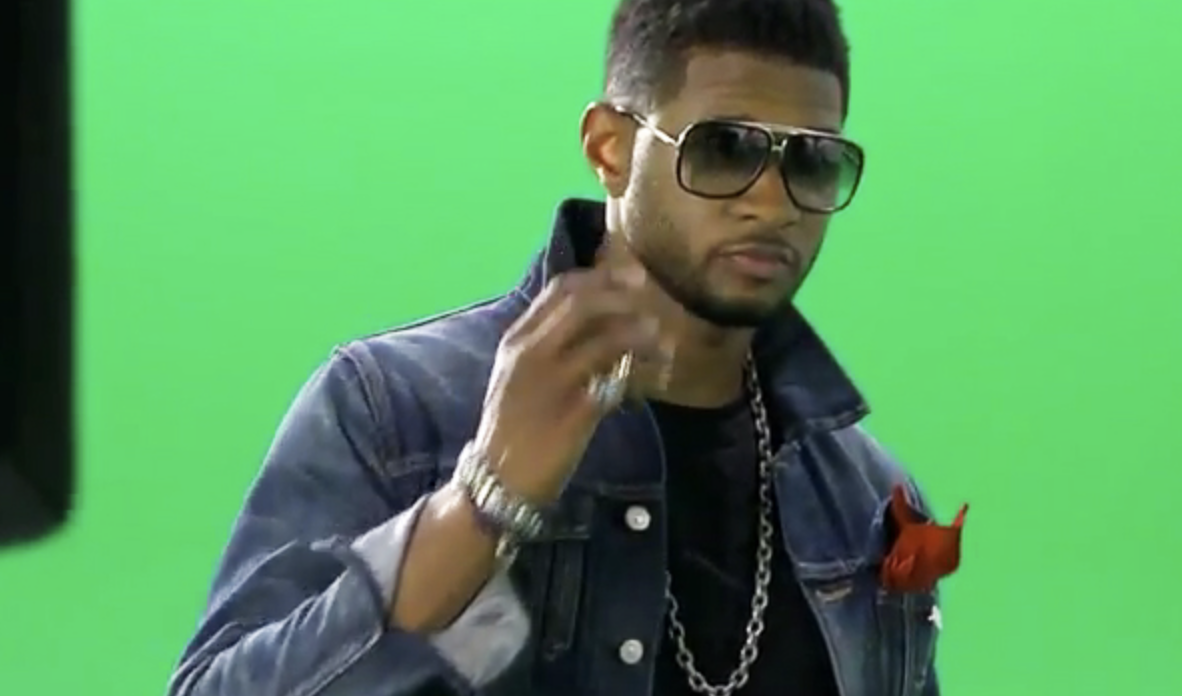

In [808]:
from IPython.display import Image
Image(filename='/Users/sambrady/usher.png')

# Part 4 - Make Playlists based off of the feature characteristics using Machine Learning technique K-Means Clustering

### Standardization of the data to fix skew and get mean=0 and std=1 in order to help with clustering


In [764]:
# Finding out the skew for each feature

skew = df_features.skew()

print(skew)

Beats Per Minute    0.737
Energy             -0.913
Danceability       -0.548
Loudness dB        -0.987
Liveness            1.720
Valence            -0.065
Length              1.339
Acousticness        2.201
Speechiness         2.543
Popularity         -1.359
dtype: float64


In [765]:
# scale the data

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_features)

df_scaled = pd.DataFrame(df_scaled)

df_scaled.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.894,1.145,0.192,0.874,-0.749,1.235,-0.225,0.224,-0.585,1.148
1,-1.305,1.394,0.801,0.287,2.614,0.521,1.123,0.465,1.957,1.078
2,0.052,0.833,0.878,1.461,0.856,0.834,-0.723,-0.210,0.753,0.937
3,0.011,1.332,0.420,0.874,-0.749,0.834,2.061,-0.691,-0.585,0.867
4,-0.401,0.833,-0.037,0.287,-0.673,-0.416,-0.108,-0.595,-0.585,0.797


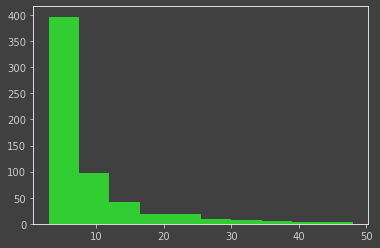

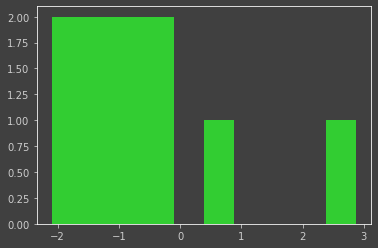

In [780]:
# Plot to show the difference

plt.hist(df_features['Speechiness'], bins=10, color='limegreen')                    #original data
plt.show()

plt.hist(df_scaled.iloc[8], bins=10, color='limegreen')                            #standardized data
plt.show()

## Find the appropriate amount of clusters


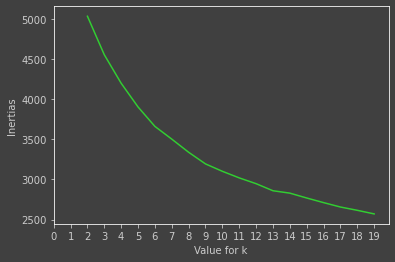

In [785]:
# choose the best number of clusters using elbow method and inertia

k = np.arange(2, 20, 1)

inertias = []

for i in k:
    km = KMeans(n_clusters=i, max_iter=1000, random_state=42)
    km.fit(df_scaled)
    inertias.append(km.inertia_)

plt.plot(k, inertias, color='limegreen')
plt.xlabel("Value for k")
plt.ylabel("Inertias")
plt.xticks(np.arange(0, 20, 1))

plt.show()

In [792]:
k = np.arange(2, 20, 1)

score=[]

for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster).fit(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
    score.append(silhouette_score(df_scaled, kmeans.labels_))
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 2 Clusters: 0.2464
Silhouette Score for 3 Clusters: 0.1408
Silhouette Score for 4 Clusters: 0.1292
Silhouette Score for 5 Clusters: 0.1306
Silhouette Score for 6 Clusters: 0.1298
Silhouette Score for 7 Clusters: 0.1236
Silhouette Score for 8 Clusters: 0.1294
Silhouette Score for 9 Clusters: 0.1148
Silhouette Score for 10 Clusters: 0.1157
Silhouette Score for 11 Clusters: 0.1213
Silhouette Score for 12 Clusters: 0.1029
Silhouette Score for 13 Clusters: 0.1066
Silhouette Score for 14 Clusters: 0.0982
Silhouette Score for 15 Clusters: 0.0976
Silhouette Score for 16 Clusters: 0.0988
Silhouette Score for 17 Clusters: 0.1131
Silhouette Score for 18 Clusters: 0.0944
Silhouette Score for 19 Clusters: 0.1051


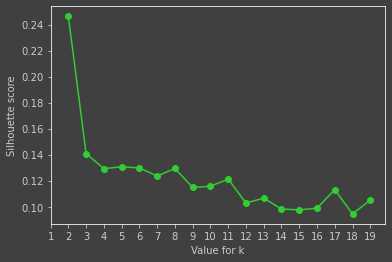

In [793]:
# plot cluster options

plt.plot(k, score, 'o-', color='limegreen')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.xticks(np.arange(1, 20, 1))

plt.show()

In [770]:
# set number of clusters

kclusters = 8


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=42).fit(df_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 5, 4, 4, 7, 4, 4, 3, 6, 4], dtype=int32)

In [771]:
# add clustering labels to dataframe

df.insert(0, 'Playlist Number', kmeans.labels_)

df.head()    # check out the Cluster Labels column!

,Playlist Number,Track Name,Artist Name,Genre,year,Beats Per Minute,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
0,4,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,5,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,4,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,7,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


In [794]:
pd.set_option('display.max_rows', None)

## Playlist #1

In [795]:
df.loc[df['Playlist Number'] == 0, df.columns[[1, 2]]]

,Track Name,Artist Name
14,Like A G6,Far East Movement
33,Imma Be,The Black Eyed Peas
40,Something's Got A Hold On Me - Burlesque Origi...,Christina Aguilera
48,Castle Walls (feat. Christina Aguilera),T.I.
75,Sexy And I Know It,LMFAO
95,Castle Walls (feat. Christina Aguilera),T.I.
100,Moment 4 Life - Album Version (Edited),Nicki Minaj
103,Muny - Album Version (Edited),Nicki Minaj
169,Thrift Shop (feat. Wanz),Macklemore & Ryan Lewis
187,Girl On Fire (feat. Nicki Minaj) - Inferno Ver...,Alicia Keys


## Playlist #2

In [796]:
df.loc[df['Playlist Number'] == 1, df.columns[[1, 2]]]

,Track Name,Artist Name
46,Written in the Stars (feat. Eric Turner),Tinie Tempah
47,DJ Got Us Fallin' In Love (feat. Pitbull),Usher
49,Break Your Heart,Taio Cruz
50,Hello,Martin Solveig
93,Written in the Stars (feat. Eric Turner),Tinie Tempah
97,Super Bass,Nicki Minaj
98,Raise Your Glass,P!nk
99,Invading My Mind,Jennifer Lopez
102,Firework,Katy Perry
136,Stereo Hearts (feat. Adam Levine),Gym Class Heroes


## Playlist #3

In [797]:
df.loc[df['Playlist Number'] == 2, df.columns[[1, 2]]]

,Track Name,Artist Name
41,Doesn't Mean Anything,Alicia Keys
59,Grenade,Bruno Mars
69,Good Life,OneRepublic
70,Just Cant Get Enough,The Black Eyed Peas
79,I Wanna Go,Britney Spears
109,I Knew You Were Trouble.,Taylor Swift
110,Call Me Maybe,Carly Rae Jepsen
115,Try,P!nk
123,Boyfriend,Justin Bieber
142,Just Give Me a Reason (feat. Nate Ruess),P!nk


## Playlist #4

In [798]:
df.loc[df['Playlist Number'] == 3, df.columns[[1, 2]]]

,Track Name,Artist Name
7,Secrets,OneRepublic
21,Whataya Want from Me,Adam Lambert
24,All The Right Moves,OneRepublic
25,Animal,Neon Trees
39,Dog Days Are Over,Florence + The Machine
42,Hard,Rihanna
68,Price Tag,Jessie J
127,Wide Awake,Katy Perry
132,We Are Young (feat. Janelle Monáe),fun.
139,Underneath the Tree,Kelly Clarkson


## Playlist #5

In [799]:
df.loc[df['Playlist Number'] == 4, df.columns[[1, 2]]]

,Track Name,Artist Name
0,"Hey, Soul Sister",Train
2,TiK ToK,Kesha
3,Bad Romance,Lady Gaga
5,Baby,Justin Bieber
6,Dynamite,Taio Cruz
9,Only Girl (In The World),Rihanna
13,Telephone,Lady Gaga
16,Eenie Meenie,Sean Kingston
19,Your Love Is My Drug,Kesha
22,Take It Off,Kesha


# Playlist #6

In [800]:
df.loc[df['Playlist Number'] == 5, df.columns[[1, 2]]]

,Track Name,Artist Name
1,Love The Way You Lie,Eminem
12,Cooler Than Me - Single Mix,Mike Posner
15,OMG (feat. will.i.am),Usher
17,The Time (Dirty Bit),The Black Eyed Peas
18,Alejandro,Lady Gaga
20,Meet Me Halfway,The Black Eyed Peas
32,Blah Blah Blah (feat. 3OH!3),Kesha
37,If I Had You,Adam Lambert
38,Rock That Body,The Black Eyed Peas
45,Not Myself Tonight,Christina Aguilera


# Playlist #7

In [801]:
df.loc[df['Playlist Number'] == 6, df.columns[[1, 2]]]

,Track Name,Artist Name
8,Empire State of Mind (Part II) Broken Down,Alicia Keys
36,Bound To You - Burlesque Original Motion Pictu...,Christina Aguilera
44,You Lost Me,Christina Aguilera
51,A Thousand Years,Christina Perri
52,Someone Like You,Adele
87,1+1,Beyoncé
94,Jar of Hearts,Christina Perri
96,Turning Page,Sleeping At Last
148,Wrecking Ball,Miley Cyrus
186,Clown,Emeli Sandé


# Playlist #8

In [802]:
df.loc[df['Playlist Number'] == 7, df.columns[[1, 2]]]

,Track Name,Artist Name
4,Just the Way You Are,Bruno Mars
10,Club Can't Handle Me (feat. David Guetta),Flo Rida
11,Marry You,Bruno Mars
29,California Gurls,Katy Perry
34,Try Sleeping with a Broken Heart,Alicia Keys
54,Just the Way You Are,Bruno Mars
64,Marry You,Bruno Mars
65,Best Thing I Never Had,Beyoncé
71,On The Floor,Jennifer Lopez
74,Without You (feat. Usher),David Guetta


# Now all we have to do is name these playlists... I'll leave that up to you!